In [68]:
import pandas as pd
import numpy as np
from datetime import datetime, date
from sweref99 import projections
from datetime import datetime, date
import matplotlib.pyplot as plt
import folium
import json
from pathlib import Path
from folium import plugins
plt.rcParams["figure.figsize"] = (18,8)

In [32]:
fire_risk_path="../data/raw/Brandriskdata 2000-2020.csv"
reported_fires_path="../data/raw/Insatser till brand i skog och mark 2000-2020.xlsx"
rtypes={ 'PunktID': str}

In [33]:
#Reading csv file from path with dtypes
reported_fire_risk = pd.read_csv(fire_risk_path, sep=';', dtype=rtypes)
reported_fires = pd.read_excel(reported_fires_path)

In [34]:
def _filter_rows_by_values(df, column, keep_values):
    return df[df[column].isin(keep_values)]

In [35]:
reported_fires = _filter_rows_by_values(reported_fires,'BEJBbrandorsakText',['Grillning eller lägereld'])
reported_fires = reported_fires.drop(columns=['tid','sweref99Ost','sweref99Norr','verksamhetText','arealProduktivSkogsmark_m2','arealAnnanTradbevuxenMark_m2','arealMarkUtanTrad_m2','BEJBbrandorsakText'])
reported_fires['Month'] = reported_fires['datum'].dt.month
reported_fires['Day'] = reported_fires['datum'].dt.day
reported_fires = reported_fires.rename(columns={"datum":"Date", "kommun":"Municipality"})

In [36]:
#Check to see number of null values in each column of the reported fires data
print(reported_fires.isnull().sum(axis = 0))
print("Total rows: ")
print(reported_fires.shape[0])

ar                0
Date              0
Municipality      0
kommunKortNamn    0
Month             0
Day               0
dtype: int64
Total rows: 
7802


In [37]:
reported_fires.head(5)

,ar,Date,Municipality,kommunKortNamn,Month,Day
41,2000,2000-01-26,861,Mönsterås,1,26
43,2000,2000-01-28,482,Flen,1,28
50,2000,2000-01-31,581,Norrköping,1,31
51,2000,2000-02-01,686,Eksjö,2,1
60,2000,2000-02-12,484,Eskilstuna,2,12


In [38]:
reported_fire_risk = reported_fire_risk.drop(columns=['Nederbord',
       'RH', 'Vindhastighet', 'Vindriktning', 'FFMC', 'DMC', 'DC', 'ISI',
       'BUI', 'HBV_o', 'HBV_u', 'HBV', 'HBV_index', 'Tmedel','Temp',
       'Gras','E','N'])
reported_fire_risk.dropna(subset=['FWI'], how='all', inplace=True)
reported_fire_risk['FWI'] = reported_fire_risk['FWI'].str.replace(',','.')
reported_fire_risk['FWI'] = reported_fire_risk['FWI'].astype(float)
reported_fire_risk['Kommun'] = reported_fire_risk['Kommun'].astype(int)
reported_fire_risk['Datum'] = pd.to_datetime(reported_fire_risk['Datum'], format='%Y-%m-%d')
reported_fire_risk = reported_fire_risk.groupby(['Datum','Kommun']).mean()
reported_fire_risk = reported_fire_risk.reset_index()
reported_fire_risk = reported_fire_risk.rename(columns={"Datum": "Date", "Kommun":"Municipality"})

In [39]:
#Check to see number of null values in each column of the firerisk data
print(reported_fire_risk.isnull().sum(axis = 0))
print("Total rows: ")
print(reported_fire_risk.shape[0])

Date            0
Municipality    0
FWI             0
FWI_index       0
dtype: int64
Total rows: 
1237770


In [40]:
reported_fire_risk.head(5)

,Date,Municipality,FWI,FWI_index
0,2000-04-01,115,5.250,2.00
1,2000-04-01,117,4.440,2.00
2,2000-04-01,120,2.325,1.25
3,2000-04-01,125,5.325,2.00
4,2000-04-01,126,4.700,2.00


In [42]:
merged = pd.merge(reported_fires, reported_fire_risk, how='inner', on=['Municipality','Date'])
merged = merged.rename(columns={ "datum":"Date", "kommun":"Municipality_name","BEJBbrandorsakText":"Cause_of_fire","kommunKortNamn":"Municipality_name","ar":"Year"})
merged


,Year,Date,Municipality,Municipality_name,Month,Day,FWI,FWI_index
0,2000,2000-04-08,1384,Kungsbacka,4,8,1.283333,1.500000
1,2000,2000-04-08,1499,Falköping,4,8,2.300000,2.000000
2,2000,2000-04-08,680,Jönköping,4,8,0.942857,1.357143
3,2000,2000-04-10,1980,Västerås,4,10,8.900000,3.000000
4,2000,2000-04-11,180,Stockholm,4,11,4.000000,2.000000
...,...,...,...,...,...,...,...,...
6481,2020,2020-10-19,188,Norrtälje,10,19,4.838095,2.142857
6482,2020,2020-10-20,1481,Mölndal,10,20,4.150000,2.000000
6483,2020,2020-10-24,1290,Kristianstad,10,24,0.753846,1.230769
6484,2020,2020-11-10,885,Borgholm,11,10,1.980000,-1.000000


In [45]:
merged.head(5)

,Year,Date,Municipality,Municipality_name,Month,Day,FWI,FWI_index
0,2000,2000-04-08,1384,Kungsbacka,4,8,1.283333,1.500000
1,2000,2000-04-08,1499,Falköping,4,8,2.300000,2.000000
2,2000,2000-04-08,680,Jönköping,4,8,0.942857,1.357143
3,2000,2000-04-10,1980,Västerås,4,10,8.900000,3.000000
4,2000,2000-04-11,180,Stockholm,4,11,4.000000,2.000000


In [46]:
mergedfwi4 = merged[merged['FWI_index']>=4]

In [47]:
mergedfwi4

,Year,Date,Municipality,Municipality_name,Month,Day,FWI,FWI_index
43,2000,2000-05-12,1285,Eslöv,5,12,17.825000,4.000000
45,2000,2000-05-12,862,Emmaboda,5,12,18.785714,4.000000
46,2000,2000-05-12,862,Emmaboda,5,12,18.785714,4.000000
49,2000,2000-05-13,1276,Klippan,5,13,25.475000,5.000000
50,2000,2000-05-13,2282,Kramfors,5,13,21.460000,4.300000
...,...,...,...,...,...,...,...,...
6431,2020,2020-08-19,381,Enköping,8,19,23.822222,4.666667
6433,2020,2020-08-20,180,Stockholm,8,20,27.200000,5.000000
6434,2020,2020-08-21,1980,Västerås,8,21,24.222222,4.888889
6439,2020,2020-08-24,980,Gotland,8,24,26.536957,5.195652


In [81]:
month_year = pd.DataFrame(columns=['fires','Sum'])
month_year['Month'] = merged['Month']
month_year['Year'] = merged['Year']
month_year['Date'] = merged['Date']
month_year= month_year.assign(fires=1)
month_year_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_year['Month_name'] = month_year['Month'].apply(lambda x: month_year_labels[x])
month_year['Date'] = pd.to_datetime(month_year['Date'], format='%Y-%m-%d')
month_year['yday'] = month_year['Date'].dt.dayofyear
month_year['Day'] = month_year['Date'].dt.day
month_year = month_year.sort_values(by=['Year','Month'])

In [80]:
month_year

,fires,Sum,Month,Year,Date,Month_name,yday,Day
0,1,NaN,4,2000,2000-04-08,Apr,99,8
1,1,NaN,4,2000,2000-04-08,Apr,99,8
2,1,NaN,4,2000,2000-04-08,Apr,99,8
3,1,NaN,4,2000,2000-04-10,Apr,101,10
4,1,NaN,4,2000,2000-04-11,Apr,102,11
...,...,...,...,...,...,...,...,...
6481,1,NaN,10,2020,2020-10-19,Oct,293,19
6482,1,NaN,10,2020,2020-10-20,Oct,294,20
6483,1,NaN,10,2020,2020-10-24,Oct,298,24
6484,1,NaN,11,2020,2020-11-10,Nov,315,10


In [54]:
month_year_fwi4 = pd.DataFrame(columns=['fires','Sum'])
month_year_fwi4['Month'] = mergedfwi4['Month']
month_year_fwi4['Year'] = mergedfwi4['Year']
month_year_fwi4['Date'] = mergedfwi4['Date']
month_year_fwi4= month_year_fwi4.assign(fires=1)
month_year_fwi4_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
month_year_fwi4['Month_name'] = month_year_fwi4['Month'].apply(lambda x: month_year_fwi4_labels[x])
month_year_fwi4['Date'] = pd.to_datetime(month_year_fwi4['Date'], format='%Y-%m-%d')
month_year_fwi4['yday'] = month_year_fwi4['Date'].dt.dayofyear
month_year_fwi4['Day'] = month_year_fwi4['Date'].dt.day
month_year_fwi4 = month_year_fwi4.sort_values(by=['Year','Month'])

In [55]:
month_year_fwi4

,fires,Sum,Month,Year,Date,Month_name,yday,Day
43,1,NaN,5,2000,2000-05-12,May,133,12
45,1,NaN,5,2000,2000-05-12,May,133,12
46,1,NaN,5,2000,2000-05-12,May,133,12
49,1,NaN,5,2000,2000-05-13,May,134,13
50,1,NaN,5,2000,2000-05-13,May,134,13
...,...,...,...,...,...,...,...,...
6431,1,NaN,8,2020,2020-08-19,Aug,232,19
6433,1,NaN,8,2020,2020-08-20,Aug,233,20
6434,1,NaN,8,2020,2020-08-21,Aug,234,21
6439,1,NaN,8,2020,2020-08-24,Aug,237,24


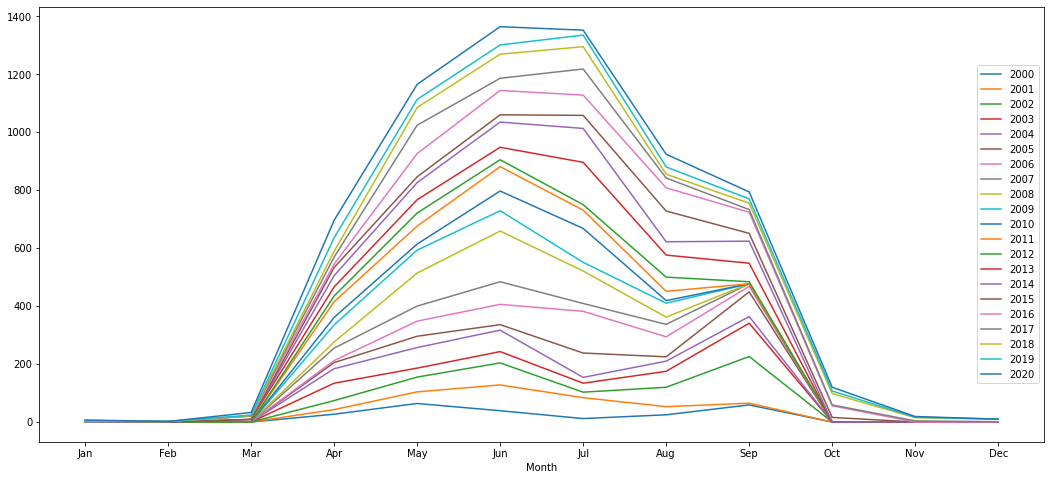

In [83]:
month_labels = ['Jan','Feb','Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov','Dec']
fig = month_year.groupby(['Month','Year']).sum().unstack()
line = fig.plot(kind='line',y='fires', stacked=True)
line.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
line.set_xticklabels(month_labels)
line.legend(loc='center right')

In [58]:
month_year_fwi4 = month_year_fwi4.reset_index()
month_labels = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
fires_day_month = pd.DataFrame(columns=['month_name','Sum'])
fires_day_month['Sum'] = month_year_fwi4.value_counts(['Year','Day','Month']).to_frame()
fires_day_month = fires_day_month.reset_index()
fires_day_month['month_name'] = fires_day_month['Month'].apply(lambda x: month_labels[x])
fires_day_month['Date'] = pd.to_datetime({'year':fires_day_month['Year'],'month': fires_day_month['Month'],'day':fires_day_month['Day']})
fires_day_month['yday'] = fires_day_month['Date'].dt.dayofyear
fires_day_month['Week'] = fires_day_month['Date'].dt.isocalendar().week

In [59]:
fires_day_month

,Year,Day,Month,month_name,Sum,Date,yday,Week
0,2008,8,6,Jun,17,2008-06-08,160,23
1,2008,3,6,Jun,16,2008-06-03,155,23
2,2008,1,6,Jun,15,2008-06-01,153,22
3,2013,23,7,Jul,14,2013-07-23,204,30
4,2008,5,6,Jun,12,2008-06-05,157,23
...,...,...,...,...,...,...,...,...
687,2006,21,7,Jul,1,2006-07-21,202,29
688,2006,22,7,Jul,1,2006-07-22,203,29
689,2014,9,7,Jul,1,2014-07-09,190,28
690,2014,9,6,Jun,1,2014-06-09,160,24


In [60]:
tablesplit = fires_day_month.set_index(['Date'])
#FutureWarning at this row
pre2019 = tablesplit.loc['2000-1-1':'2018-12-31']
#FutureWarning at this row
pre2019['year_group'] = '2000-2018'
post2018 = tablesplit.loc['2019-1-1' : '2020-12-31']
post2018['year_group'] = '2019-2020 '
post2018.sort_values(by='yday')
fires_day_month_v2 = pd.concat([pre2019,post2018])
fires_day_month_v2= fires_day_month_v2.reset_index()
fires_day_month_v2 = fires_day_month_v2.sort_values(by='Date')
fires_day_month_v2['rol5'] = fires_day_month_v2[['Date','Sum']].rolling(5).mean()
fires_day_month_v2['rol14'] = fires_day_month_v2[['Date','Sum']].rolling(14).mean()
fires_day_month_v2['rol7'] = fires_day_month_v2[['Date','Sum']].rolling(14).mean()

C:\Users\Johan\AppData\Local\Temp/ipykernel_9436/3032295884.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  pre2019 = tablesplit.loc['2000-1-1':'2018-12-31']
C:\Users\Johan\AppData\Local\Temp/ipykernel_9436/3032295884.py:6: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  post2018 = tablesplit.loc['2019-1-1' : '2020-12-31']


In [61]:
fires_day_month_v2

,Date,Year,Day,Month,month_name,Sum,yday,Week,year_group,rol5,rol14,rol7
170,2000-05-12,2000,12,5,May,3,133,19,2000-2018,NaN,NaN,NaN
196,2000-05-13,2000,13,5,May,3,134,19,2000-2018,NaN,NaN,NaN
41,2000-05-14,2000,14,5,May,6,135,19,2000-2018,NaN,NaN,NaN
348,2000-05-15,2000,15,5,May,2,136,20,2000-2018,NaN,NaN,NaN
342,2000-05-16,2000,16,5,May,2,137,20,2000-2018,3.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
673,2020-08-19,2020,19,8,Aug,1,232,34,2019-2020,1.8,1.428571,1.428571
671,2020-08-20,2020,20,8,Aug,1,233,34,2019-2020,1.8,1.428571,1.428571
669,2020-08-21,2020,21,8,Aug,1,234,34,2019-2020,1.6,1.357143,1.357143
666,2020-08-24,2020,24,8,Aug,1,237,35,2019-2020,1.4,1.285714,1.285714


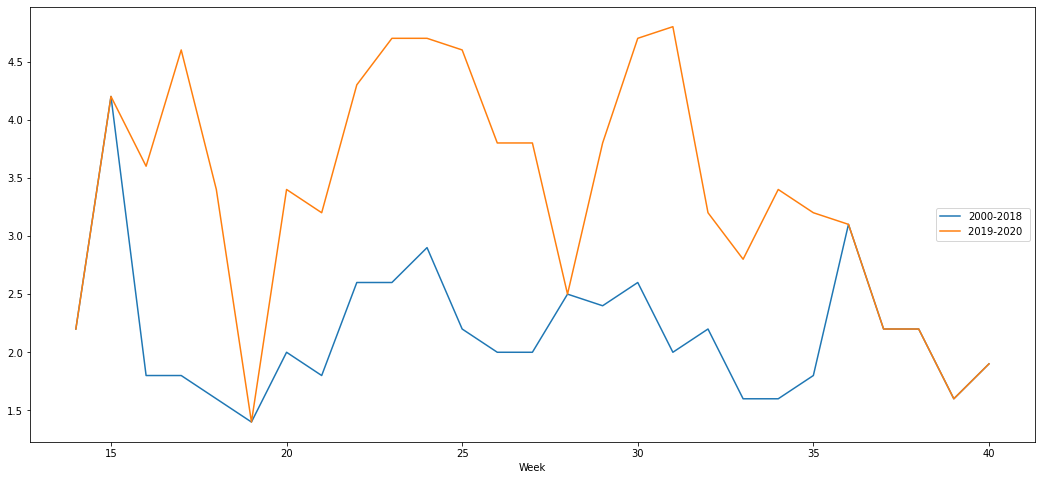

In [63]:
fig = fires_day_month_v2.groupby(['Week','year_group']).median().unstack()
line = fig.plot(kind='line',y='rol5', stacked=True)
#plt.xticks(np.linspace(4,10,8)[:-1], ('Apr','May','Jun','Jul','Aug','Sep','Oct'))
line.legend(loc='center right')

In [75]:
merged['Municipality_name'] = merged['Municipality_name'].replace('Malung','Malung-Sälen')
fire_muni = mergedfwi4
fire_muni = fire_muni[['Date','Municipality_name']]
allyears = pd.DataFrame(columns=['fires'])
fire_muni_pre2019 = pd.DataFrame(columns=['fires'])
fire_muni_post2018 = pd.DataFrame(columns=['fires'])
tt = fire_muni.set_index(['Date'])
fire_muni_pre2019 = tt.loc['2000-01-01':'2018-12-31']
fire_muni_pre2019['year_group'] = '2000-2018'
fire_muni_post2018 = tt.loc['2019-01-01' : '2020-12-31']
fire_muni_post2018['year_group'] = '2019-2020'
fire_muni_post2018.sort_values(by='Date')
allyears = pd.concat([fire_muni_pre2019,fire_muni_post2018])
allyears = allyears.assign(fires=1)
fire_muni_pre2019 = fire_muni_pre2019.assign(fires=1)
fire_muni_post2018 = fire_muni_post2018.assign(fires=1)
allyears = allyears.groupby(allyears['Municipality_name']).sum()
allyears= allyears.reset_index()
fire_muni_pre2019= fire_muni_pre2019.groupby(fire_muni_pre2019['Municipality_name']).sum()
fire_muni_pre2019= fire_muni_pre2019.reset_index()
fire_muni_post2018= fire_muni_post2018.groupby(fire_muni_post2018['Municipality_name']).sum()
fire_muni_post2018= fire_muni_post2018.reset_index()

C:\Users\Johan\AppData\Local\Temp/ipykernel_9436/3956668312.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_muni_pre2019['year_group'] = '2000-2018'
C:\Users\Johan\AppData\Local\Temp/ipykernel_9436/3956668312.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fire_muni_post2018['year_group'] = '2019-2020'


In [69]:
path = Path("../data/raw/sweden-municipalities-topo.json")
with open(path,encoding='utf-8') as f:
    muni_topo = json.load(f)

In [76]:
map = folium.Map(location = [59.334591, 18.063240], zoom_start = 5.45)
folium.Choropleth(geo_data=muni_topo,
topojson='objects.SWE_adm2',
key_on='feature.properties.NAME_2',
data=allyears, # What dataset to visualize
columns=['Municipality_name','fires'], 
fill_color='OrRd', 
fill_opacity=0.9, 
line_opacity=0.5,
legend_name="Number of reported fires",
).add_to(map)


In [77]:
map

In [23]:
#Creates table from the firerisktable grouped on the columns Datum and Kommun, with the median, giving us the median values of FWI_index for each Kommun and each day
totalfwi4 = reported_fire_risk.groupby(['Date','Municipality']).median()
totalfwi4 = reported_fire_risk.reset_index()
# Gives us table with for all the times FWI_index was => 4 (eldningsförbud)
above4risk = totalfwi4[totalfwi4['FWI_index']>=4]
above4risk = above4risk.set_index(['Date'])
pre2018risk = above4risk.loc['2000-1-1':'2017-12-31']
pre2019risk = above4risk.loc['2000-1-1':'2018-12-31']
post2018risk = above4risk.loc['2019-1-1' : '2020-12-31']
risk2000 = above4risk.loc['2000-1-1' : '2000-12-31']
risk2001 = above4risk.loc['2001-1-1' : '2001-12-31']
risk2002 = above4risk.loc['2002-1-1' : '2002-12-31']
risk2003 = above4risk.loc['2003-1-1' : '2003-12-31']
risk2004 = above4risk.loc['2004-1-1' : '2004-12-31']
risk2005 = above4risk.loc['2005-1-1' : '2005-12-31']
risk2006 = above4risk.loc['2006-1-1' : '2006-12-31']
risk2007 = above4risk.loc['2007-1-1' : '2007-12-31']
risk2008 = above4risk.loc['2008-1-1' : '2008-12-31']
risk2009 = above4risk.loc['2009-1-1' : '2009-12-31']
risk2010 = above4risk.loc['2010-1-1' : '2010-12-31']
risk2011 = above4risk.loc['2011-1-1' : '2011-12-31']
risk2012 = above4risk.loc['2012-1-1' : '2012-12-31']
risk2013 = above4risk.loc['2013-1-1' : '2013-12-31']
risk2014 = above4risk.loc['2014-1-1' : '2014-12-31']
risk2015 = above4risk.loc['2015-1-1' : '2015-12-31']
risk2016 = above4risk.loc['2016-1-1' : '2016-12-31']
risk2017 = above4risk.loc['2017-1-1' : '2017-12-31']
risk2018 = above4risk.loc['2018-1-1' : '2018-12-31']
risk2019 = above4risk.loc['2019-1-1' : '2019-12-31']
risk2020 = above4risk.loc['2020-1-1' : '2029-12-31']

In [24]:
risk2020

,index,Municipality,FWI,FWI_index
Date,,,,
2020-04-06,1162217,586,17.880000,4.0
2020-04-06,1162259,1231,17.300000,4.0
2020-04-06,1162263,1260,19.700000,4.0
2020-04-06,1162275,1277,22.500000,5.0
2020-04-07,1162486,512,19.583333,4.0
...,...,...,...,...
2020-09-24,1210138,1230,19.500000,4.0
2020-09-24,1210139,1231,18.700000,4.0
2020-09-24,1210145,1263,22.800000,5.0


In [25]:
merged['Date'] = pd.to_datetime({'year':merged['Year'],'month': merged['Month'],'day':merged['Day']})
tablesplit = merged.set_index(['Date'])
pre2018 = tablesplit.loc['2000-1-1':'2017-12-31']
pre2019 = tablesplit.loc['2000-1-1':'2018-12-31']
post2018 = tablesplit.loc['2019-1-1' : '2020-12-31']
fires2000 = tablesplit.loc['2000-1-1' : '2000-12-31']
fires2001 = tablesplit.loc['2001-1-1' : '2001-12-31']
fires2002 = tablesplit.loc['2002-1-1' : '2002-12-31']
fires2003 = tablesplit.loc['2003-1-1' : '2003-12-31']
fires2004 = tablesplit.loc['2004-1-1' : '2004-12-31']
fires2005 = tablesplit.loc['2005-1-1' : '2005-12-31']
fires2006 = tablesplit.loc['2006-1-1' : '2006-12-31']
fires2007 = tablesplit.loc['2007-1-1' : '2007-12-31']
fires2008 = tablesplit.loc['2008-1-1' : '2008-12-31']
fires2009 = tablesplit.loc['2009-1-1' : '2009-12-31']
fires2010 = tablesplit.loc['2010-1-1' : '2010-12-31']
fires2011 = tablesplit.loc['2011-1-1' : '2011-12-31']
fires2012 = tablesplit.loc['2012-1-1' : '2012-12-31']
fires2013 = tablesplit.loc['2013-1-1' : '2013-12-31']
fires2014 = tablesplit.loc['2014-1-1' : '2014-12-31']
fires2015 = tablesplit.loc['2015-1-1' : '2015-12-31']
fires2016 = tablesplit.loc['2016-1-1' : '2016-12-31']
fires2017 = tablesplit.loc['2017-1-1' : '2017-12-31']
fires2018 = tablesplit.loc['2018-1-1' : '2018-12-31']
fires2019 = tablesplit.loc['2019-1-1' : '2019-12-31']
fires2020 = tablesplit.loc['2020-1-1' : '2020-12-31']

In [26]:
fires2020

,Year,Municipality,Municipality_name,Month,Day,FWI,FWI_index
Date,,,,,,,
2020-04-13,2020,1281,Lund,4,13,29.000000,5.500000
2020-04-17,2020,480,Nyköping,4,17,24.545455,4.818182
2020-04-21,2020,881,Nybro,4,21,23.737500,5.000000
2020-04-23,2020,1290,Kristianstad,4,23,29.092308,5.461538
2020-04-26,2020,128,Salem,4,26,17.000000,4.000000
...,...,...,...,...,...,...,...
2020-08-19,2020,381,Enköping,8,19,23.822222,4.666667
2020-08-20,2020,180,Stockholm,8,20,27.200000,5.000000
2020-08-21,2020,1980,Västerås,8,21,24.222222,4.888889
